In [15]:
import sys
sys.path.append("../../..")

In [16]:
import pandas as pd

##### read fixed mutation data

In [17]:
fixed_mutation_sheet = pd.read_excel('../../../data/fixed_mutation(1).xlsx', sheet_name='Sheet1')
fixed_mutation_sheet

,CHROM,Position,REF,ALT,refrence allele,up stream,down stram,file_name,QUAL,SVTYPE,...,LOH_fixed_by_10150,present_at_10150,ID,mutation_group,group_mutation_type,group_mutation_impact,in_telomere,ref_flank,alt_flank,population_name
0,2-micron,141,C,T,C,GCGAGACAAA,AGGACAATTA,NaN,23994.97,NaN,...,0.0,1,2-micron_141_T,1,noncoding,NaN,0,GCGAGACAAACAGGACAATTA,GCGAGACAAATAGGACAATTA,P3C07
1,2-micron,2576,T,C,T,GTGACCTTTG,ATTGACAAAT,NaN,22083.79,NaN,...,1.0,1,2-micron_2576_C,2,missense,MODERATE,0,GTGACCTTTGTATTGACAAAT,GTGACCTTTGCATTGACAAAT,P3C07
2,2-micron,2986,G,A,G,CTTAATACAA,CAAGCAGTCT,NaN,24140.52,NaN,...,1.0,1,2-micron_2986_A,3,missense,MODERATE,0,CTTAATACAAGCAAGCAGTCT,CTTAATACAAACAAGCAGTCT,P3C07
3,2-micron,3082,T,C,T,TACAGAAGGT,TTCGCGGTTT,NaN,25546.51,NaN,...,1.0,1,2-micron_3082_C,4,noncoding,MODIFIER,0,TACAGAAGGTTTTCGCGGTTT,TACAGAAGGTCTTCGCGGTTT,P3C07
4,2-micron,4525,G,A,G,CGCATACTTT,TGAACAGAAA,NaN,21905.18,NaN,...,1.0,1,2-micron_4525_A,6,noncoding,NaN,0,CGCATACTTTGTGAACAGAAA,CGCATACTTTATGAACAGAAA,P3C07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25694,chrXVI,851553,A,T,A,GTATATGTTG,GCAAGTGTGT,NaN,386.35,NaN,...,1.0,1,chrXVI_851553_T,200,missense,MODERATE,0,GTATATGTTGAGCAAGTGTGT,GTATATGTTGTGCAAGTGTGT,P2F09
25695,chrXVI,867714,G,A,G,TTGTCTTCGT,GTCGAATCTA,NaN,506.66,NaN,...,0.0,1,chrXVI_867714_A,201,synonymous,LOW,0,TTGTCTTCGTGGTCGAATCTA,TTGTCTTCGTAGTCGAATCTA,P2F09
25696,chrXVI,898887,C,A,C,GGCCTATGAC,CGCTGGAACA,NaN,1715.24,NaN,...,0.0,1,chrXVI_898887_A,202,missense,MODERATE,0,GGCCTATGACCCGCTGGAACA,GGCCTATGACACGCTGGAACA,P2F09
25697,chrXVI,941276,G,T,G,AAATGGGTTT,TTCACGCCAT,NaN,831.57,NaN,...,0.0,1,chrXVI_941276_T,203,noncoding,NaN,0,AAATGGGTTTGTTCACGCCAT,AAATGGGTTTTTTCACGCCAT,P2F09


##### read gain sheet

In [18]:
ag_sheet = pd.read_excel('../../../data/fixed_mutation(1).xlsx', sheet_name='Sheet2')
ag_sheet

,Min log_likelihood_gain,Position,CHROM,REF,ALT,group_mutation_type,population_name,G70_ref_counts,G1410_ref_counts,G2640_ref_counts,...,G7530_ref_counts,G10150_ref_counts,G70_alt_counts,G1410_alt_counts,G2640_alt_counts,G5150_alt_counts,G7530_alt_counts,G10150_alt_counts,accumulate_gain,Max log_likelihood_gain
0,-1.223775,141,2-micron,C,T,noncoding,P3C07,107,0,4,...,5,0,0,8,22,18,20,2,0.460847,0.875469
1,-0.810930,2576,2-micron,T,C,missense,P3C07,107,0,5,...,1,0,0,11,13,16,15,0,-2.585438,0.000000
2,0.000000,2986,2-micron,G,A,missense,P3C07,107,0,3,...,3,0,0,9,13,14,20,7,6.325886,1.232144
3,-1.417066,3082,2-micron,T,C,noncoding,P3C07,107,0,4,...,5,0,0,12,18,24,6,10,-4.901611,0.405465
4,-0.656780,4525,2-micron,G,A,noncoding,P3C07,107,0,10,...,2,0,0,9,25,12,7,5,1.634026,0.777705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25227,-0.802346,851553,chrXVI,A,T,missense,P2F09,0,0,0,...,0,0,0,0,0,0,0,13,-4.976722,-0.223144
25228,-0.367725,867714,chrXVI,G,A,synonymous,P2F09,49,36,50,...,54,24,0,0,0,0,0,17,2.969015,1.098612
25229,-1.386294,898887,chrXVI,C,A,missense,P2F09,47,30,27,...,16,15,0,0,8,17,28,8,1.565519,1.098612
25230,0.048790,941276,chrXVI,G,T,noncoding,P2F09,59,36,60,...,69,22,0,0,0,0,0,27,5.688471,1.280934


##### Merge gain and fixed count dataframes on common columns

In [19]:
merged_df = pd.merge(fixed_mutation_sheet, ag_sheet[['CHROM', 'Position', 'REF', 'ALT', 'population_name', 'group_mutation_type', 'accumulate_gain']], 
                     on=['CHROM', 'Position', 'REF', 'ALT', 'population_name', 'group_mutation_type'], 
                     how='left')

In [20]:
merged_df

,CHROM,Position,REF,ALT,refrence allele,up stream,down stram,file_name,QUAL,SVTYPE,...,present_at_10150,ID,mutation_group,group_mutation_type,group_mutation_impact,in_telomere,ref_flank,alt_flank,population_name,accumulate_gain
0,2-micron,141,C,T,C,GCGAGACAAA,AGGACAATTA,NaN,23994.97,NaN,...,1,2-micron_141_T,1,noncoding,NaN,0,GCGAGACAAACAGGACAATTA,GCGAGACAAATAGGACAATTA,P3C07,0.460847
1,2-micron,2576,T,C,T,GTGACCTTTG,ATTGACAAAT,NaN,22083.79,NaN,...,1,2-micron_2576_C,2,missense,MODERATE,0,GTGACCTTTGTATTGACAAAT,GTGACCTTTGCATTGACAAAT,P3C07,-2.585438
2,2-micron,2986,G,A,G,CTTAATACAA,CAAGCAGTCT,NaN,24140.52,NaN,...,1,2-micron_2986_A,3,missense,MODERATE,0,CTTAATACAAGCAAGCAGTCT,CTTAATACAAACAAGCAGTCT,P3C07,6.325886
3,2-micron,3082,T,C,T,TACAGAAGGT,TTCGCGGTTT,NaN,25546.51,NaN,...,1,2-micron_3082_C,4,noncoding,MODIFIER,0,TACAGAAGGTTTTCGCGGTTT,TACAGAAGGTCTTCGCGGTTT,P3C07,-4.901611
4,2-micron,4525,G,A,G,CGCATACTTT,TGAACAGAAA,NaN,21905.18,NaN,...,1,2-micron_4525_A,6,noncoding,NaN,0,CGCATACTTTGTGAACAGAAA,CGCATACTTTATGAACAGAAA,P3C07,1.634026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25694,chrXVI,851553,A,T,A,GTATATGTTG,GCAAGTGTGT,NaN,386.35,NaN,...,1,chrXVI_851553_T,200,missense,MODERATE,0,GTATATGTTGAGCAAGTGTGT,GTATATGTTGTGCAAGTGTGT,P2F09,-4.976722
25695,chrXVI,867714,G,A,G,TTGTCTTCGT,GTCGAATCTA,NaN,506.66,NaN,...,1,chrXVI_867714_A,201,synonymous,LOW,0,TTGTCTTCGTGGTCGAATCTA,TTGTCTTCGTAGTCGAATCTA,P2F09,2.969015
25696,chrXVI,898887,C,A,C,GGCCTATGAC,CGCTGGAACA,NaN,1715.24,NaN,...,1,chrXVI_898887_A,202,missense,MODERATE,0,GGCCTATGACCCGCTGGAACA,GGCCTATGACACGCTGGAACA,P2F09,1.565519
25697,chrXVI,941276,G,T,G,AAATGGGTTT,TTCACGCCAT,NaN,831.57,NaN,...,1,chrXVI_941276_T,203,noncoding,NaN,0,AAATGGGTTTGTTCACGCCAT,AAATGGGTTTTTTCACGCCAT,P2F09,5.688471


##### Reshape dataframe for box plot

In [21]:
# Columns for box plot
columns_for_box_plot = ['fixed_by_70', 'fixed_by_1410', 'fixed_by_2640', 'fixed_by_5150', 'fixed_by_7530', 'fixed_by_10150']

# Convert True to 1 and False to 0
merged_df[columns_for_box_plot] = merged_df[columns_for_box_plot].astype(int)

# Melt the DataFrame for box plot
df_melted = pd.melt(merged_df, id_vars=['accumulate_gain'], value_vars=columns_for_box_plot, var_name='Mutation Type', value_name='Fixed')


In [22]:
df_melted['Fixed'] = df_melted['Fixed'].replace({0: "False", 1: "True"})

In [23]:
df_melted

,accumulate_gain,Mutation Type,Fixed
0,0.460847,fixed_by_70,False
1,-2.585438,fixed_by_70,False
2,6.325886,fixed_by_70,False
3,-4.901611,fixed_by_70,False
4,1.634026,fixed_by_70,False
...,...,...,...
154189,-4.976722,fixed_by_10150,True
154190,2.969015,fixed_by_10150,True
154191,1.565519,fixed_by_10150,False
154192,5.688471,fixed_by_10150,True


In [24]:
# import numpy as np
# np.array_equal(np.array(merged_df[['fixed_by_10150']]).ravel(), np.array(df_melted[df_melted.loc[:, "Mutation Type"]=="fixed_by_10150"][['Fixed']]).ravel())

In [25]:
def custom_figure_axis(ax, fontsize=10, show_ticks = True, rotation=90):
    
        
    """
    Customize the appearance of matplotlib axis for a figure.
    
    Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The axis to be customized.
        fontsize (int, optional): Font size for axis labels and ticks. Default is 10.
        show_ticks (bool, optional): Whether to display ticks and labels. Default is True.
    
    Returns:
        matplotlib.axes._subplots.AxesSubplot: The customized axis.
    """
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.2)
    ax.spines['left'].set_linewidth(0.2)
    ax.tick_params(axis='x', labelsize=fontsize, rotation=rotation)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.tick_params(axis='both', which='both', width=0.5)
    ax.xaxis.label.set_fontsize(fontsize)
    ax.yaxis.label.set_fontsize(fontsize)
    
    if show_ticks==False:
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    return ax

##### kGain vs mutation type 

Text(0, 0.5, 'kGain')

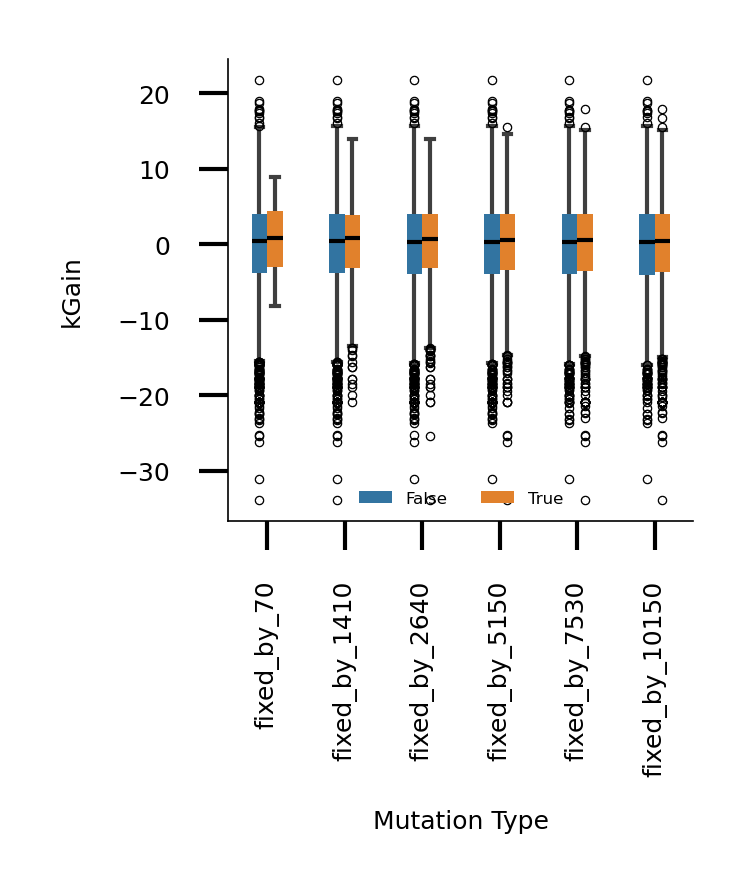

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, dpi = 600, figsize=(1,1))

ax = sns.boxplot(df_melted, y="accumulate_gain", x = "Mutation Type", hue = "Fixed", ax=ax, boxprops=dict(edgecolor="black", linewidth=0),flierprops=dict(marker='o', markeredgecolor='black'), width=0.4,linewidth=0.5, fliersize=0.15, dodge=True,  medianprops={"color": "black","linewidth":0.5})
ax= custom_figure_axis(ax, fontsize=3)
ax.legend(ncol = 2, fontsize=2, frameon=False)
ax.set_ylabel("kGain")

In [27]:

def man_whiteney(group1, group2):   
    
    """
    Perform a one-sided Mann-Whitney U test and return the p-value.
    
    This function compares two independent groups and tests if 'group1' tends to have larger values than 'group2'.
    
    Parameters:
        group1 (array-like): The data of the first group.
        group2 (array-like): The data of the second group.
    
    Returns:
        float: The p-value from the one-sided Mann-Whitney U test.
    
    Notes:
        The null hypothesis is that the distribution of 'group1' is not greater than 'group2'.
    """

    from scipy.stats import mannwhitneyu
    statistic, p_value = mannwhitneyu(group1, group2, alternative='greater', nan_policy = "omit")
    return p_value

##### Find generation wise p value

In [28]:
# tmp = pd

for i in set(df_melted["Mutation Type"]):

    tmp = df_melted[df_melted.loc[:, "Mutation Type"]==i]

    print("The one sided Mann-Whitney of  generation " + i + " is" + str(man_whiteney(tmp[tmp.loc[:, "Fixed"]=="True"]["accumulate_gain"], tmp[tmp.loc[:, "Fixed"]=="False"]["accumulate_gain"])))


The one sided Mann-Whitney of  generation fixed_by_7530 is0.001030949030906248
The one sided Mann-Whitney of  generation fixed_by_5150 is0.0016369263156367025
The one sided Mann-Whitney of  generation fixed_by_70 is0.16623128307670126
The one sided Mann-Whitney of  generation fixed_by_1410 is0.03188925206092693
The one sided Mann-Whitney of  generation fixed_by_10150 is0.00046802296607905504
The one sided Mann-Whitney of  generation fixed_by_2640 is0.00238463283807234
